In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

from scipy.stats import shapiro
from statsmodels.stats.diagnostic import acorr_ljungbox

In [2]:
df = pd.read_csv("air_passengers.csv").rename(
    columns={"Passengers": "y", "Month": "ds"}
)

### Lag Features and Target

In [3]:
df["target"] = df["y"].shift(-1)
for i in range(1, 12):
    df[f"y{-i}"] = df["y"].shift(i)

In [4]:
df.dropna(inplace=True)

In [5]:
df.reset_index(drop=True, inplace=True)

### Split DataFrame

In [6]:
X = df.filter(like="y", axis=1).values
y = df["target"].values.reshape(-1, 1)

### Cross validation and Grid Search

In [7]:
ridge_model = Ridge()

param_grid = {
    "alpha": np.linspace(0.1, 2, 40),
    "fit_intercept": [True, False],
    "max_iter": [10000000],
    "tol": np.linspace(0.1, 2, 40),
    "solver": ["svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"],
}

tscv = TimeSeriesSplit(n_splits=12, test_size=1)

In [8]:
grid_search = GridSearchCV(
    ridge_model,
    param_grid,
    scoring="neg_mean_squared_error",
    cv=tscv,
    n_jobs=-1,
    verbose=1,
)
grid_search.fit(X, y)

Fitting 12 folds for each of 19200 candidates, totalling 230400 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=12, test_size=1),
             estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([0.1       , 0.14871795, 0.1974359 , 0.24615385, 0.29487179,
       0.34358974, 0.39230769, 0.44102564, 0.48974359, 0.53846154,
       0.58717949, 0.63589744, 0.68461538, 0.73333333, 0.78205128,
       0.83076923, 0.87948718, 0.92820513, 0.97692308, 1.02564103,...
       0.58717949, 0.63589744, 0.68461538, 0.73333333, 0.78205128,
       0.83076923, 0.87948718, 0.92820513, 0.97692308, 1.02564103,
       1.07435897, 1.12307692, 1.17179487, 1.22051282, 1.26923077,
       1.31794872, 1.36666667, 1.41538462, 1.46410256, 1.51282051,
       1.56153846, 1.61025641, 1.65897436, 1.70769231, 1.75641026,
       1.80512821, 1.85384615, 1.9025641 , 1.95128205, 2.        ])},
             scoring='neg_mean_squared_error', verbose=1)

### Get the Best!!!

In [9]:
best_params_ = grid_search.best_params_
best_ridge_model = Ridge(**best_params_)

### Looking Back

In [10]:
df_res = pd.DataFrame()
df_res_aux = pd.DataFrame()

for i, (train_index, test_index) in enumerate(tscv.split(df)):

    X = df.filter(like="y", axis=1).iloc[train_index]

    y = df.iloc[train_index]["target"].values.reshape(-1, 1)

    best_ridge_model.fit(X, y)

    df.at[test_index[0], "pred"] = best_ridge_model.predict(

        df.filter(like="y", axis=1).iloc[test_index]

    )[0][0]

### Erros

In [11]:
df_erro = df[["ds", "y", "pred"]].dropna()
df_erro["APE"] = np.abs((df_erro["y"] - df_erro["pred"]) / df_erro["y"]) * 100
df_erro["MAPE"] = df_erro["APE"].mean()
df_erro["MSE"] = mean_squared_error(df_erro["y"], df_erro["pred"])
df_erro["RMSE"] = np.sqrt(df_erro["MSE"])
df_erro["R2"] = r2_score(df_erro["y"], df_erro["pred"])

c:\Users\herbe\anaconda3\envs\TS_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\herbe\anaconda3\envs\TS_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


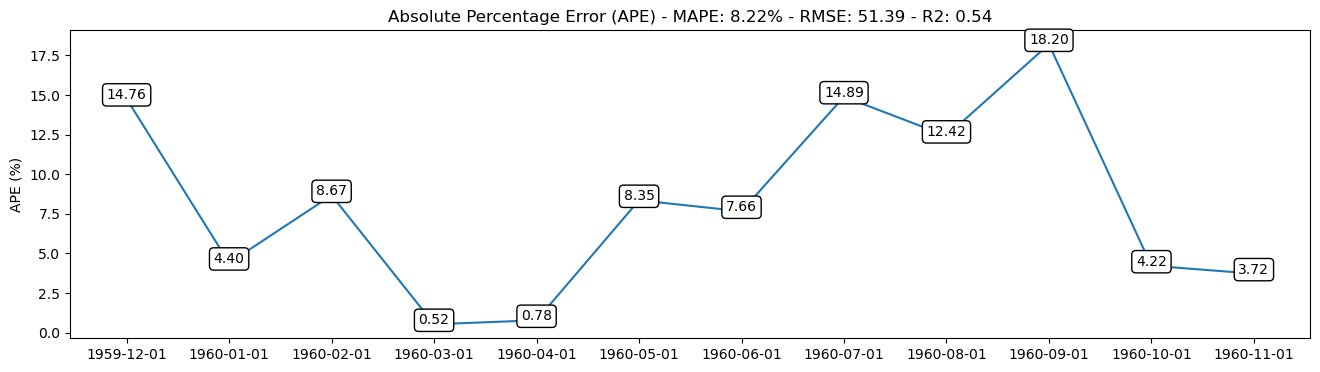

In [12]:
plt.figure(figsize=(16, 4))
sns.lineplot(x="ds", y="APE", data=df_erro).set(
    xlabel="",
    ylabel="APE (%)",
    title=f'Absolute Percentage Error (APE) - MAPE: {df_erro["MAPE"].values[0]:.2f}% - RMSE: {df_erro["RMSE"].values[0]:.2f} - R2: {df_erro["R2"].values[0]:.2f}',
)

for index, row in df_erro.iterrows():
    plt.annotate(
        f'{row["APE"]:.2f}',
        (row["ds"], row["APE"]),
        textcoords="offset points",
        xytext=(0, 0),
        ha="center",
        bbox=dict(boxstyle="round", fc="w"),
    )

### Residuals 

In [13]:
best_ridge_model.fit(df.filter(like="y", axis=1), df["target"].values.reshape(-1, 1))
df["res"] = best_ridge_model.predict(df.filter(like="y", axis=1))
df["res"] = df["target"] - df["res"]

In [14]:
shapiro_test = shapiro(df["res"])
shapiro_statistic = shapiro_test.statistic
shapiro_p_value = shapiro_test.pvalue

lb, p_value = acorr_ljungbox(df["res"], lags=[12])

print(f"Shapiro-Wilk test statistic: {shapiro_statistic}")
print(f"Shapiro-Wilk test p-value: {shapiro_p_value}")
print(f"Ljung-Box test p-value: {p_value[0]}")

Shapiro-Wilk test statistic: 0.941433310508728
Shapiro-Wilk test p-value: 2.2942269424675032e-05
Ljung-Box test p-value: l


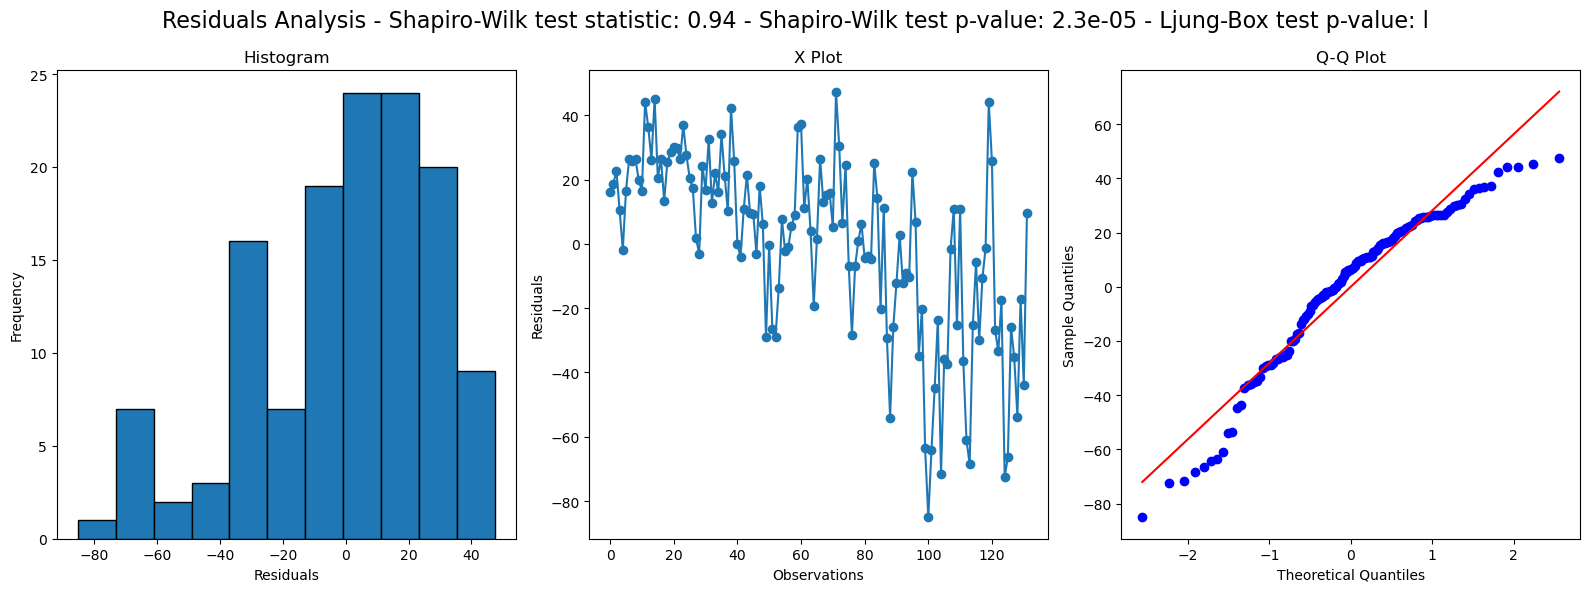

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))

axs[0].hist(df["res"], bins=int(df["res"].shape[0] ** 0.5), edgecolor="black")
axs[0].set_title("Histogram")
axs[0].set_xlabel("Residuals")
axs[0].set_ylabel("Frequency")

axs[1].plot(df["res"], marker="o")
axs[1].set_title("X Plot")
axs[1].set_xlabel("Observations")
axs[1].set_ylabel("Residuals")

stats.probplot(df["res"], dist="norm", plot=axs[2])
axs[2].set_title("Q-Q Plot")
axs[2].set_xlabel("Theoretical Quantiles")
axs[2].set_ylabel("Sample Quantiles")

fig.suptitle(
    f"Residuals Analysis - Shapiro-Wilk test statistic: {shapiro_statistic:.2} - Shapiro-Wilk test p-value: {shapiro_p_value:.2} - Ljung-Box test p-value: {p_value[0]}",
    fontsize=16,
)

plt.tight_layout()
plt.show()